<a href="https://colab.research.google.com/github/olegov99/text-classification/blob/main/text_classification_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from warnings import filterwarnings
filterwarnings("ignore")

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

drive.mount('/content/drive')

TRAIN_DATA_PATH = '/content/drive/MyDrive/nlp-course/ag-news-dataset/train.csv'
TEST_DATA_PATH = '/content/drive/MyDrive/nlp-course/ag-news-dataset/test.csv'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [2]:
test_data = pd.read_csv(TEST_DATA_PATH)
train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
train_data.shape

(120000, 3)

In [4]:
test_data.shape

(7600, 3)

In [5]:
train_data.isna().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [6]:
# 1 - World, 2 - Sports, 3 - Business, 4 - Sci/Tech

train_data['Class Index'].value_counts()

4    30000
3    30000
2    30000
1    30000
Name: Class Index, dtype: int64

In [7]:
# Constants for class indexes

WORLD = 1
SPORTS = 2
BUSINESS = 3
SCI_TECH = 4

## Data Preprocessing

In [8]:
# Combining Title and Description columns

train_data['combined_text'] = train_data['Title'] + ' ' + train_data['Description']
test_data['combined_text'] = test_data['Title'] + ' ' + test_data['Description']

train_data.head()

,Class Index,Title,Description,combined_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [9]:
STOPWORDS = nltk.corpus.stopwords.words('english')

tokenizer = WordPunctTokenizer()

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

def remove_punctuation(text):
  return "".join([i for i in text if i not in punctuation])

def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])


def preprocess_data(data):
  # Lower Casing
  data['preprocessed_text'] = data['combined_text'].apply(lambda x: x.lower())

  # Remove Punctuation
  data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: remove_punctuation(x))

  # Remove Stopwords
  data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: remove_stopwords(x))

  # Tokenization
  data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: tokenizer.tokenize(x))

  # Lemmitization
  data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: lemmatize_words(x))

preprocess_data(train_data)
preprocess_data(test_data)

train_data.head()

,Class Index,Title,Description,combined_text,preprocessed_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,"[wall, st, bear, claw, back, black, reuters, r..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,"[carlyle, look, toward, commercial, aerospace,..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[oil, economy, cloud, stock, outlook, reuters,..."
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,"[iraq, halt, oil, export, main, southern, pipe..."
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...","[oil, price, soar, alltime, record, pose, new,..."


Посмотрим на 30 самых часто встречающихся слов после препроцессинга данных

In [10]:
nltk.FreqDist([word for row in train_data['preprocessed_text'] for word in row]).most_common(30)

[('39s', 31218),
 ('say', 28715),
 ('new', 21370),
 ('u', 19393),
 ('reuters', 17243),
 ('ap', 16148),
 ('year', 10886),
 ('company', 9915),
 ('first', 9044),
 ('two', 8920),
 ('world', 8392),
 ('report', 7710),
 ('game', 7630),
 ('monday', 7480),
 ('wednesday', 7348),
 ('tuesday', 7291),
 ('oil', 7228),
 ('one', 7203),
 ('thursday', 7159),
 ('make', 6941),
 ('take', 6901),
 ('week', 6734),
 ('price', 6715),
 ('friday', 6709),
 ('state', 6674),
 ('win', 6669),
 ('inc', 6632),
 ('last', 6371),
 ('plan', 6353),
 ('39', 6182)]

Удалим несколько слов с наибольшей частотой.

In [11]:
MOST_FREQ_WORDS = ['ap', 'reuters', 'afp', 'say', '39s', 'u', 'new', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'yesterday', 'sunday', 'saturday', 'one', 'two'] # Слова с наибольшей частотой, а также дни недели

train_data['preprocessed_text'] = train_data['preprocessed_text'].apply(lambda x: [word for word in x if not word in MOST_FREQ_WORDS])
test_data['preprocessed_text'] = test_data['preprocessed_text'].apply(lambda x: [word for word in x if not word in MOST_FREQ_WORDS])
nltk.FreqDist([word for row in train_data['preprocessed_text'] for word in row]).most_common(30)

[('year', 10886),
 ('company', 9915),
 ('first', 9044),
 ('world', 8392),
 ('report', 7710),
 ('game', 7630),
 ('oil', 7228),
 ('make', 6941),
 ('take', 6901),
 ('week', 6734),
 ('price', 6715),
 ('state', 6674),
 ('win', 6669),
 ('inc', 6632),
 ('last', 6371),
 ('plan', 6353),
 ('39', 6182),
 ('york', 6162),
 ('iraq', 6033),
 ('million', 6031),
 ('kill', 6024),
 ('president', 5924),
 ('time', 5741),
 ('lead', 5583),
 ('microsoft', 5582),
 ('day', 5326),
 ('group', 5317),
 ('security', 5296),
 ('get', 5184),
 ('service', 5163)]

# Data Visualization

In [12]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [13]:
def get_text_by_class(class_index):
  return " ".join(train_data[train_data['Class Index'] == class_index]['preprocessed_text'].str.join(" "))

def build_worldcloud(text):
  wordcloud = WordCloud(width=1000, height=1000, max_words=100, background_color="white").generate(text)

  plt.figure(figsize = (10, 10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

def plot_word_freq_hist(data):
  freq_dict = nltk.FreqDist(data.split(" ")).most_common(30)
  freq_df = {
      'words': [item[0] for item in freq_dict],
      'freq': [item[1] for item in freq_dict]
  }
  plt.figure(figsize=(12,4))
  sns.barplot(data=freq_df, x="words", y="freq")
  plt.title('Words by Frequency', fontsize=12)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Word', fontsize=12)
  plt.xticks(rotation=90)
  plt.show();

### 'World' category

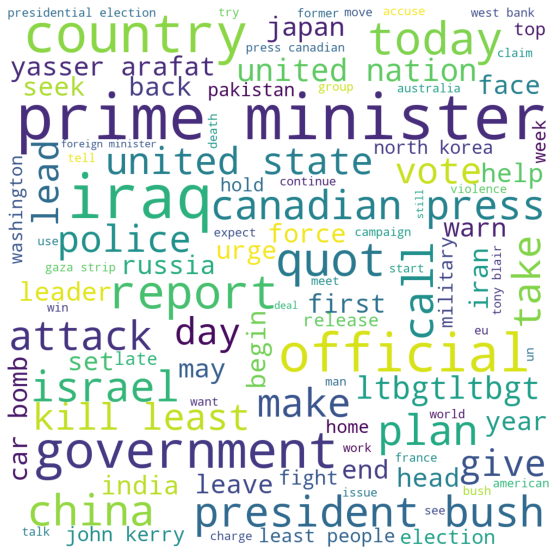

In [14]:
world_text = get_text_by_class(WORLD)
build_worldcloud(world_text)

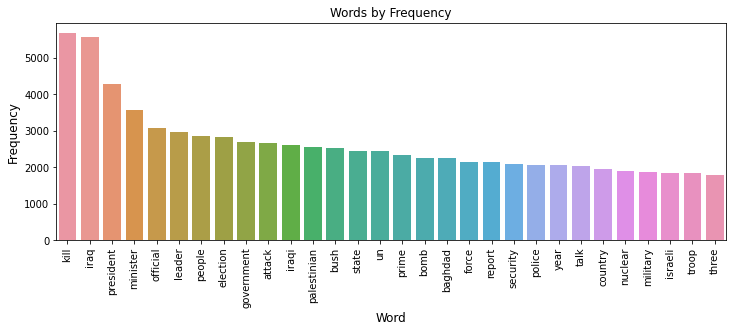

In [15]:
plot_word_freq_hist(world_text)

### 'Sports' category

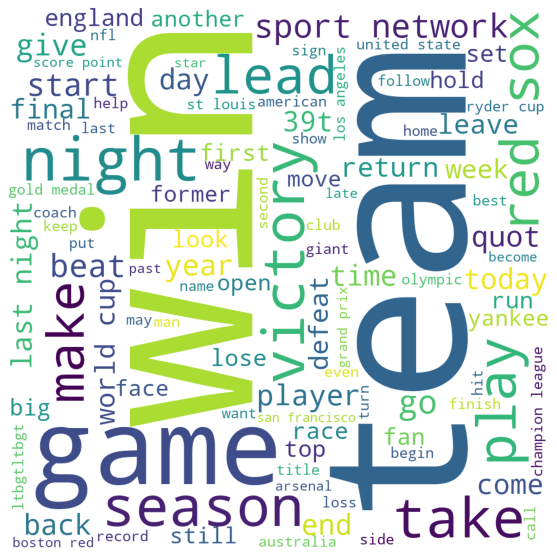

In [16]:
sports_text = get_text_by_class(SPORTS)
build_worldcloud(sports_text)

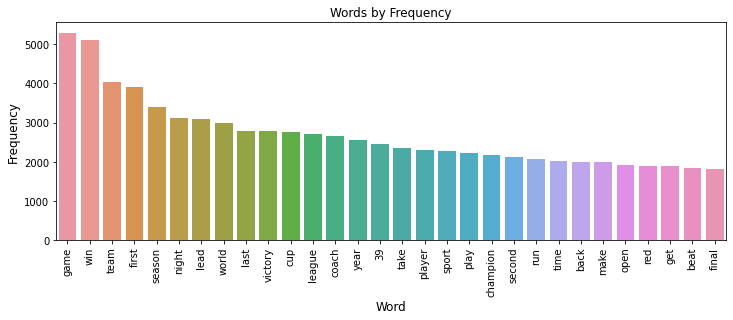

In [17]:
plot_word_freq_hist(sports_text)

### 'Business' category

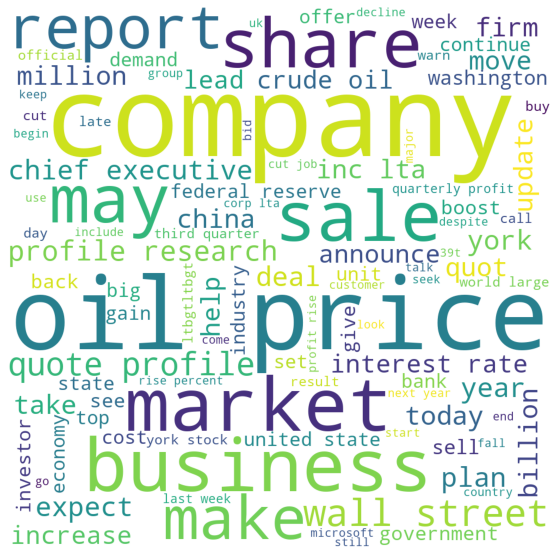

In [18]:
business_text = get_text_by_class(BUSINESS)
build_worldcloud(business_text)

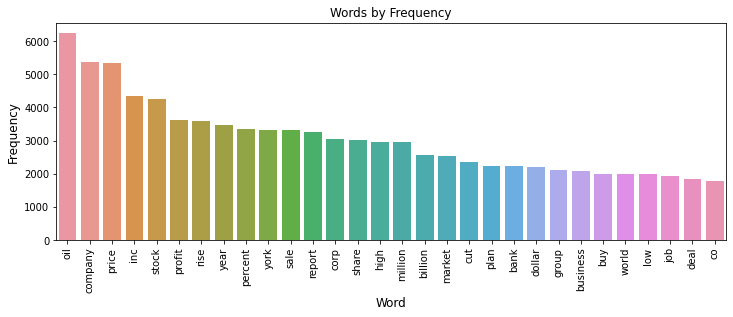

In [19]:
plot_word_freq_hist(business_text)

### 'Sci/Tech' category

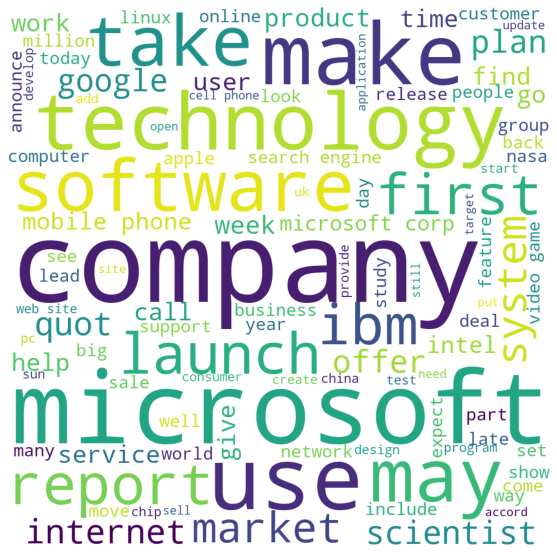

In [20]:
sci_tech_text = get_text_by_class(SCI_TECH)
build_worldcloud(sci_tech_text)

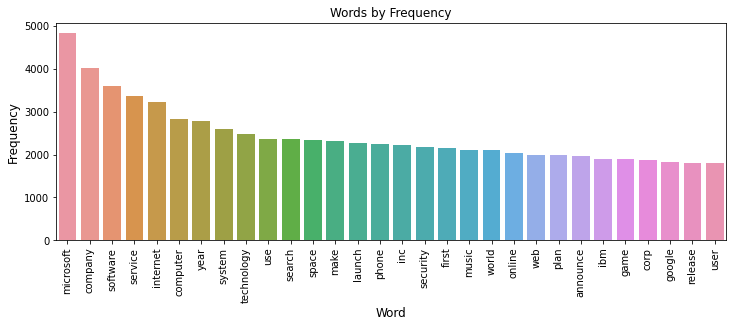

In [21]:
plot_word_freq_hist(sci_tech_text)

# Word Vectors

In [22]:
from gensim.models import Word2Vec
import gensim.downloader as api

In [23]:
train_test_preprocessed = pd.concat([train_data, test_data])['preprocessed_text']
train_test_preprocessed

0       [wall, st, bear, claw, back, black, shortselle...
1       [carlyle, look, toward, commercial, aerospace,...
2       [oil, economy, cloud, stock, outlook, soar, cr...
3       [iraq, halt, oil, export, main, southern, pipe...
4       [oil, price, soar, alltime, record, pose, mena...
                              ...                        
7595    [around, world, ukrainian, presidential, candi...
7596    [void, fill, clement, supply, attractive, pitc...
7597    [martinez, leave, bitter, like, roger, clemens...
7598    [5, arthritis, patient, singapore, take, bextr...
7599    [ebay, get, rental, ebay, plan, buy, apartment...
Name: preprocessed_text, Length: 127600, dtype: object

In [24]:
model = Word2Vec(train_test_preprocessed, size=64, min_count=5, window=10)

In [25]:
model.wv.most_similar('software')

[('database', 0.7097333669662476),
 ('apps', 0.7013056874275208),
 ('antispyware', 0.6725727319717407),
 ('antivirus', 0.6714699268341064),
 ('application', 0.6690236330032349),
 ('opensource', 0.6670017838478088),
 ('vendor', 0.6584590673446655),
 ('tool', 0.6584572792053223),
 ('suite', 0.6560112833976746),
 ('ebusiness', 0.653256893157959)]

In [26]:
model.wv.most_similar('victory')

[('win', 0.8725686073303223),
 ('beat', 0.8097621202468872),
 ('defeat', 0.7953518629074097),
 ('triumph', 0.7408719062805176),
 ('scored', 0.7322602272033691),
 ('crush', 0.7027447819709778),
 ('overcome', 0.7018022537231445),
 ('upset', 0.6843410730361938),
 ('beating', 0.6791672706604004),
 ('rout', 0.6758466958999634)]

In [27]:
model.wv.most_similar('business')

[('buyer', 0.6573131084442139),
 ('hardware', 0.6284675002098083),
 ('consolidate', 0.6101842522621155),
 ('profitable', 0.6078085899353027),
 ('management', 0.5996521711349487),
 ('megadeals', 0.5951678156852722),
 ('portfolio', 0.5862395763397217),
 ('customer', 0.5833463668823242),
 ('sector', 0.5799074172973633),
 ('ibms', 0.5776655077934265)]

In [28]:
model.train(train_test_preprocessed, total_examples=model.corpus_count, epochs=35)

(103447916, 107476460)

In [29]:
model.wv.most_similar('software')

[('technology', 0.6309584975242615),
 ('microsoft', 0.6304985284805298),
 ('application', 0.6269854307174683),
 ('computer', 0.6082080602645874),
 ('product', 0.6011901497840881),
 ('tool', 0.5987781882286072),
 ('linux', 0.5821372866630554),
 ('server', 0.5700266361236572),
 ('antispyware', 0.5573632717132568),
 ('wordperfect', 0.5565953254699707)]

In [30]:
model.wv.most_similar('victory')

[('win', 0.8816624283790588),
 ('defeat', 0.8205877542495728),
 ('beat', 0.7953699827194214),
 ('triumph', 0.7732178568840027),
 ('rout', 0.6598936319351196),
 ('drub', 0.6427306532859802),
 ('trounce', 0.6321518421173096),
 ('score', 0.6045100688934326),
 ('upset', 0.6040319800376892),
 ('beating', 0.5939361453056335)]

In [31]:
model.wv.most_similar('business')

[('company', 0.669320821762085),
 ('buyer', 0.6279511451721191),
 ('customer', 0.6217551231384277),
 ('portfolio', 0.6154086589813232),
 ('sector', 0.5987657308578491),
 ('mediumsized', 0.5928382873535156),
 ('selfservice', 0.5923141241073608),
 ('management', 0.5901502370834351),
 ('market', 0.5746179819107056),
 ('unit', 0.5723142027854919)]

In [32]:
import numpy as np

def get_vectors_for_texts(data, model):
  X_data = []
  y_data = []
  for text, class_index in zip(data['preprocessed_text'], data['Class Index']):
    text_vectors = np.array([model.wv.get_vector(word) for word in text if word in model.wv.vocab])
    if len(text_vectors) > 0:
      text_vector = np.mean(text_vectors, axis=0)
      X_data.append(text_vector)
      y_data.append(class_index)
  return X_data, y_data


# Classical Machine Learning Models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [37]:
def preprocess_data_with_config(_data, preprocessing_config):
  data = _data.copy()
  # Lower Casing
  data['preprocessed_text'] = data['combined_text'].apply(lambda x: x.lower())

  # Remove Punctuation
  if (preprocessing_config.get('remove_punctuation')):
    data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: remove_punctuation(x))

  # Remove Stopwords
  if (preprocessing_config.get('remove_stopwords')):
    data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: remove_stopwords(x))
    data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: " ".join([word for word in str(x).split() if word not in MOST_FREQ_WORDS]))

  # Tokenization
  data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: tokenizer.tokenize(x))

  # Lemmitization
  if (preprocessing_config.get('lemmatize')):
    data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: lemmatize_words(x))

  return data

### Logistic Regression

In [38]:
config = {
    'remove_punctuation': False,
    'remove_stopwords': False,
    'lemmatize': False
}

log_reg_params = {
    'C': [0.1,1,10]
}

for key in config.keys():
  config[key] = True
  log_reg = LogisticRegression(max_iter=1000)
  train_preprocessed_data = preprocess_data_with_config(train_data, config)
  test_preprocessed_data = preprocess_data_with_config(test_data, config)
  train_test_combined = pd.concat([train_preprocessed_data, test_preprocessed_data])['preprocessed_text']
  w2v_model = Word2Vec(train_test_combined, size=64, min_count=5, window=10)
  w2v_model.train(train_test_combined, total_examples=w2v_model.corpus_count, epochs=35)
  X_train, y_train = get_vectors_for_texts(train_preprocessed_data, w2v_model)
  X_test, y_test = get_vectors_for_texts(test_preprocessed_data, w2v_model)
  current_config_str = "+".join([key for key, value in config.items() if value is True])
  print('*********************************************************************')
  print(f'{current_config_str}')
  print('*********************************************************************')
  log_reg_grid=GridSearchCV(log_reg, log_reg_params).fit(X_train, y_train)
  y_pred = log_reg_grid.predict(X_test)
  acc = metrics.accuracy_score(y_test, y_pred)
  report = classification_report(y_true=y_test, y_pred=y_pred)
  print(f'Best Model: {log_reg_grid.best_estimator_}')
  print(' ')
  print(f'Test Accuracy: {acc}')
  print(' ')
  print(report)

*********************************************************************
remove_punctuation
*********************************************************************
Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
 
Test Accuracy: 0.8828947368421053
 
              precision    recall  f1-score   support

           1       0.90      0.88      0.89      1900
           2       0.94      0.96      0.95      1900
           3       0.85      0.84      0.84      1900
           4       0.85      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

*******************************

### Random Forest Classifier

In [39]:
config = {
    'remove_punctuation': False,
    'remove_stopwords': False,
    'lemmatize': False
}

rf_params = { 
    'n_estimators': [50, 100],
    'max_depth' : [2, 4],
    'min_samples_split': [2, 4],
}

for key in config.keys():
  config[key] = True
  rfc = RandomForestClassifier()
  train_preprocessed_data = preprocess_data_with_config(train_data, config)
  test_preprocessed_data = preprocess_data_with_config(test_data, config)
  train_test_combined = pd.concat([train_preprocessed_data, test_preprocessed_data])['preprocessed_text']
  w2v_model = Word2Vec(train_test_combined, size=64, min_count=5, window=10)
  w2v_model.train(train_test_combined, total_examples=w2v_model.corpus_count, epochs=35)
  X_train, y_train = get_vectors_for_texts(train_preprocessed_data, w2v_model)
  X_test, y_test = get_vectors_for_texts(test_preprocessed_data, w2v_model)
  current_config_str = "+".join([key for key, value in config.items() if value is True])
  print('*********************************************************************')
  print(f'{current_config_str}')
  print('*********************************************************************')
  rf_grid=GridSearchCV(rfc, rf_params).fit(X_train, y_train)
  y_pred = rf_grid.predict(X_test)
  acc = metrics.accuracy_score(y_test, y_pred)
  report = classification_report(y_true=y_test, y_pred=y_pred)
  print(f'Best Model: {rf_grid.best_estimator_}')
  print(' ')
  print(f'Test Accuracy: {acc}')
  print(' ')
  print(report)

*********************************************************************
remove_punctuation
*********************************************************************
Best Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
 
Test Accuracy: 0.8361842105263158
 
              precision    recall  f1-score   support

           1       0.85      0.86      0.86      1900
           2       0.90      0.93      0.92      1900
           3       0.80      0.78      0.79      1900
           4       0.79      0

Для данного датасета Логистическая регрессия показала наилучший результат: LogRegression ~0.88 vs RandomForest ~0.84 